# Word Cloud & Keyword Analysis (YouTube Titles)

โน้ตบุ๊กนี้ช่วยสร้าง **Word Cloud, Top Keywords และ Bigram Analysis** จากคอลัมน์ `Title` ของไฟล์ CSV ที่ดึงมาจาก YouTube (เช่น โหนกระแส)

รองรับภาษาไทยโดยใช้ `pythainlp` และฟอนต์ไทย เช่น TH Sarabun, Noto Sans Thai, Leelawadee


##  ขั้นที่ 1 — ติดตั้งไลบรารี (ทำใน venv ของโปรเจกต์)
```bash
python -m pip install wordcloud pythainlp pandas matplotlib
```
หากไม่มีฟอนต์ไทยในเครื่อง → ติดตั้งฟอนต์ (เช่น TH Sarabun New) และแก้ `font_path` 
ในโค้ดด้านล่าง

In [ ]:
# pip install wordcloud pythainlp pandas matplotlib

## ขั้นที่ 2 — โหลดข้อมูล & หา Font ภาษาไทย

In [56]:
import pandas as pd
from matplotlib import font_manager

CSV_PATH = "Scarping_nuenglc.csv"  # ปรับชื่อไฟล์ตามจริง
df = pd.read_csv(CSV_PATH, encoding="utf-8-sig")
df.head()

# ----- หา font ภาษาไทย -----
def find_thai_font():
    candidates = ["Sarabun", "TH Sarabun", "Noto Sans Thai", "Leelawadee", "Tahoma", "K2D"]
    for fpath in font_manager.findSystemFonts():
        lower = fpath.lower()
        if any(k.lower().replace(" ", "") in lower.replace(" ", "") for k in candidates):
            return fpath
    return None  # ถ้าไม่มี ให้ระบุ path เอง

THAI_FONT = find_thai_font()
print("Thai font:", THAI_FONT)


Thai font: C:\Users\Oatbarley\AppData\Local\Microsoft\Windows\Fonts\THSarabun BoldItalic.ttf


## ขั้นที่ 3 — ทำความสะอาดข้อความ & ตัดคำภาษาไทย

In [57]:
import re
from collections import Counter
from pythainlp import word_tokenize
from pythainlp.corpus import thai_stopwords

titles = df["Title"].dropna().astype(str).tolist()

# --- Normalizer helpers ---
PUNCT_TAIL = r"\.\,、，。!！\?？:：;；·•\-–—"   # trailing punctuation to strip
ZW = r"[\u200b\ufeff]"                          # zero-width
EMOJI_RE = re.compile(r"[\U0001F300-\U0001FAFF\U00002700-\U000027BF]")

def normalize_token(w: str) -> str:
    """Lowercase, strip hashtags/@, zero-width, trailing punct, and emojis."""
    w = w.strip()
    w = re.sub(r"^[#@]+", "", w)           
    w = re.sub(ZW, "", w)                  # remove zero-width
    w = re.sub(EMOJI_RE, "", w)            # remove common emojis
    w = re.sub(f"[{PUNCT_TAIL}]+$", "", w) # strip trailing punctuation variants
    return w.casefold()                    # case-insensitive

# --- Stopwords ---
stop_th = set(map(normalize_token, thai_stopwords()))
custom_stop_raw = {
    "ep","nuenglc","ตอน","เจอ","ดี"

}
channel_name_core = "nuenglc"

custom_stop = set(map(normalize_token, custom_stop_raw))
stop_all = stop_th | custom_stop



# --- Cleaning ---
def clean_text(s: str) -> str:
    s = s.strip()
    s = re.sub(r"http\S+", " ", s)     # remove URLs
    s = re.sub(ZW, " ", s)             # remove zero-width
    # keep punctuation minimal so Thai tokenization isn't harmed
    s = re.sub(r"[(){}\[\]\|*\"'`~^=+<>@#$%&_]", " ", s)
    return s

# --- Tokenize & filter ---
tokens = []
NUMLIKE_RE = re.compile(r"^[0-9]+([.:/\-][0-9]+)*$")  # numbers, times, dates

for t in titles:
    t = clean_text(t)
    toks = word_tokenize(t, engine="newmm", keep_whitespace=False)
    for w in toks:
        nw = normalize_token(w)
        if len(nw) < 2:               # very short tokens
            continue
        if NUMLIKE_RE.match(nw):      # numbers/time/date-like strings
            continue
        if nw in stop_all:            # remove channel name & common filler
            continue
        tokens.append(nw)

freq = Counter(tokens)
print("Sample tokens:", tokens[:50])
print("Unique tokens:", len(freq))


Sample tokens: ['พัสดุ', 'สยองขวัญ', 'แปลก', 'ทำงาน', 'ไรเดอร์', 'หลอน', 'สั่ง', '.461', 'บ้าน', 'วิทยาลัย', 'ทน', 'สัญญา', 'เก่ง', 'ระยอง', 'หลอน', 'สั่ง', '.460', 'ยืม', 'ผี', 'เจ้าของ', 'ทวง', 'ถึงกับ', 'หลอน', 'หลอน', 'สั่ง', '.459', 'ไม้', 'ผี', 'บ้าน', 'คน', 'ชั้นล่าง', 'คน', 'ชั้นบน', 'ผี', 'หนองคาย', 'หลอน', 'สั่ง', 'พิเศษ', 'ครั้งสุดท้าย', 'ชีวิต', 'เข้าไป', 'คน', 'เตือน', 'ว่าที่', 'ผี', 'ดุ', 'หลอน', 'สั่ง', '.457', 'ศพ']
Unique tokens: 1969


## ขั้นที่ 4 — Word Cloud + Top Keywords

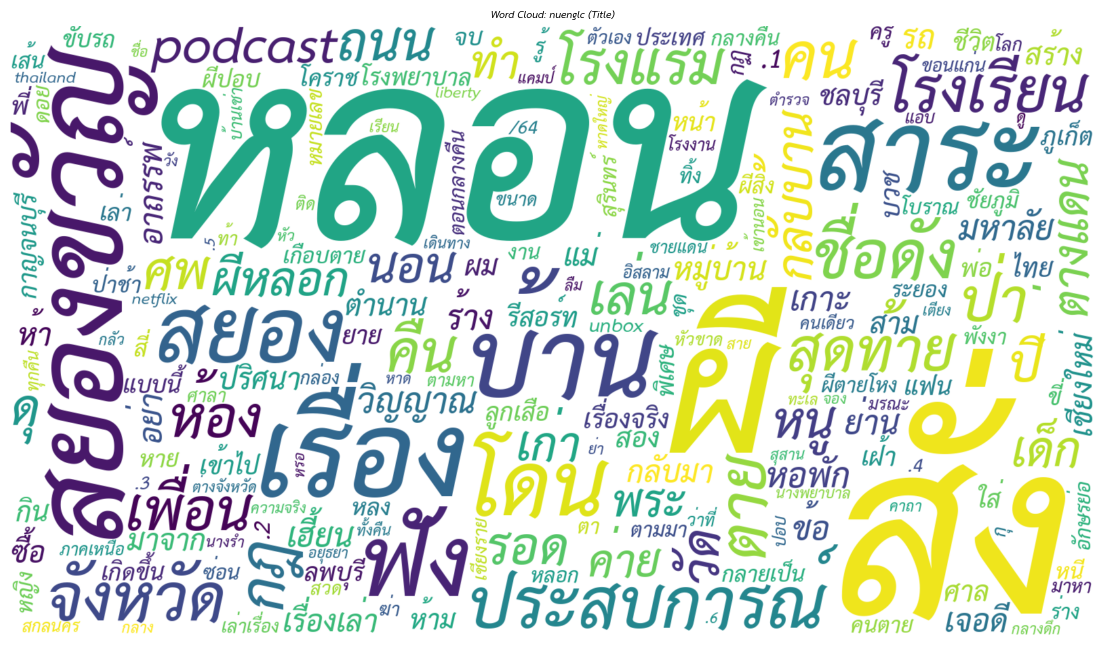

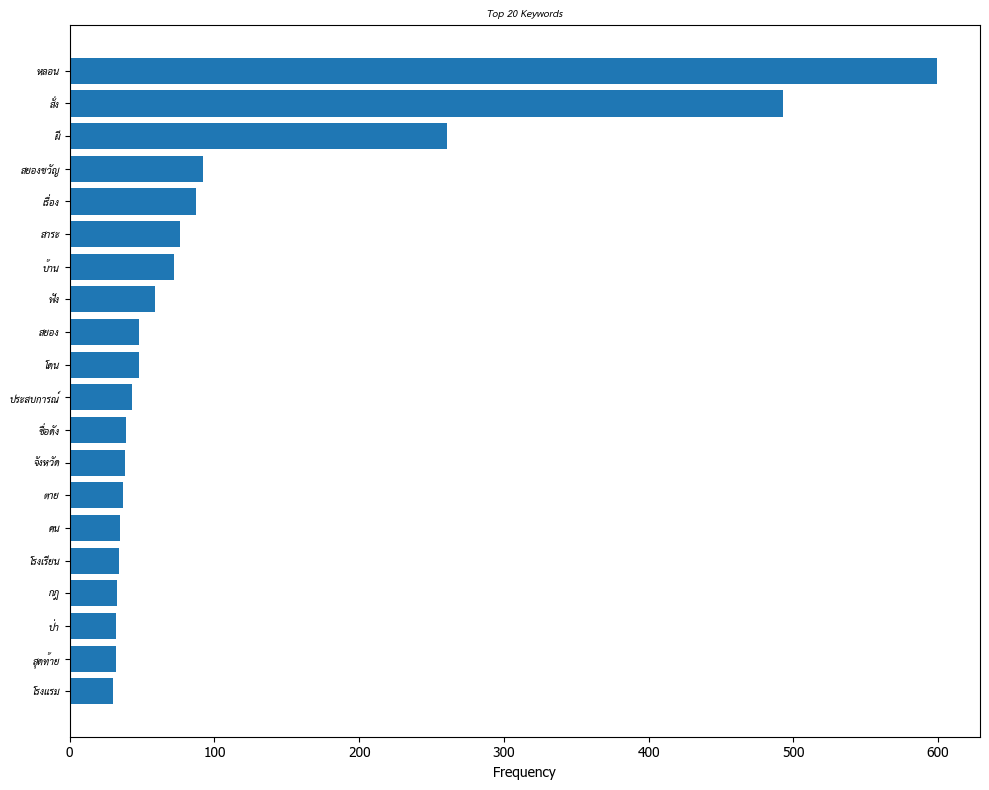

In [63]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# ----- Word Cloud -----
wc = WordCloud(
    font_path=THAI_FONT,
    width=1600, height=900,
    background_color="white",
    collocations=False
)
wc.generate_from_frequencies(freq)

plt.figure(figsize=(14,8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud: nuenglc (Title)", fontproperties=font_manager.FontProperties(fname=THAI_FONT) if THAI_FONT else None)
plt.show()

# ----- Top Keywords (barh) -----
TOP_N = 20
top_items = freq.most_common(TOP_N)
words = [w for w,c in top_items][::-1]
counts = [c for w,c in top_items][::-1]

plt.figure(figsize=(10,8))
plt.barh(words, counts)
if THAI_FONT:
    plt.yticks(fontproperties=font_manager.FontProperties(fname=THAI_FONT))
plt.title(f"Top {TOP_N} Keywords", fontproperties=font_manager.FontProperties(fname=THAI_FONT) if THAI_FONT else None)
plt.xlabel("Frequency")
plt.tight_layout()
plt.show()


## ขั้นที่ 5 — Bigram Analysis (วลี 2 คำ)

In [59]:
def bigrams(seq):
    for i in range(len(seq)-1):
        yield (seq[i], seq[i+1])

bigrams_all = list(bigrams(tokens))
bigram_freq = Counter(bigrams_all)

TOP_BI = 30
for (w1,w2), c in bigram_freq.most_common(TOP_BI):
    print(f"{w1} {w2} : {c}")


หลอน สั่ง : 490
เรื่อง สยองขวัญ : 32
ฟัง หลอน : 28
เรื่อง ผี : 23
ผี ดุ : 22
สั่ง ฟัง : 21
หลอน podcast : 21
หลอน ต่างแดน : 18
โดน ผีหลอก : 18
ประสบการณ์ สยอง : 15
ผี หลอน : 15
ชื่อดัง หลอน : 14
กฎ หลอน : 14
เรื่อง หลอน : 14
มหาลัย ชื่อดัง : 13
ประสบการณ์ หลอน : 12
กฎ ข้อ : 12
ประสบการณ์ สยองขวัญ : 11
ดุ หลอน : 10
ผี ประสบการณ์ : 9
ค่าย ลูกเสือ : 9
ชลบุรี หลอน : 9
โดน ผี : 8
ตาย หลอน : 8
เล่น เด็ก : 8
ผี บ้าน : 7
สั่ง พิเศษ : 7
ห้า เรื่อง : 7
บ้าน หลอน : 7
ฟัง เรื่อง : 6


## ขั้นตอนที่ 6 ทำการแยกประเภทของคลิป แปลงค่าเป็นวัน/เดือน/ปี และ แปลงค่าเวลาของคลิป

In [60]:
import pandas as pd
from datetime import datetime, timedelta
import re

def classify_content(title: str) -> str:
    title = str(title).lower().strip()

    categories = {
        "เรื่องผี": [r"\bผี\b", r"เปรต", r"สมิง", r"อาถรรพ์", r"ปอป", r"กระสือ", r"พญา"],
        "ตำนาน / ประวัติศาสตร์": [r"ตำนาน", r"ประวัติ", r"โบราณ", r"อารยธรรม", r"จังหวัด", r"ภาค"],
        "เรื่องจริง": [r"เรื่องจริง", r"เหตุการณ์จริง", r"เกิดขึ้นจริง", r"อิงเหตุการณ์", r"ประสบการณ์"],
        "นิยาย": [r"the shaman", r"นนท์เดอะซีรีส์", r"กฎ"],
        "เรื่องเล่า": [r"หลอน", r"อสูร", r"กฎ", r"ตาย", r"ศพ", r"มหาลัย", r"โรงแรม", r"โรงพยาบาล"],
    }

    for category, keywords in categories.items():
        for kw in keywords:
            if re.search(kw, title):
                return category
    return "อื่น ๆ"


def parse_published_date(date_str: str):
    if not isinstance(date_str, str):
        return None
    date_str = date_str.lower().replace('published on', '').strip()
    try:
        return datetime.strptime(date_str, '%b %d, %Y')
    except ValueError:
        return None


def parse_relative_date(date_str: str, now: datetime = None):
    if not isinstance(date_str, str):
        return None
    if now is None:
        now = datetime.now()

    date_str = date_str.lower().strip()
    match = re.match(r'(\d+)\s*(วินาที|นาที|ชั่วโมง|วัน|สัปดาห์|เดือน|ปี)(ที่ผ่านมา|ที่แล้ว)', date_str)    
    if not match:
        return None

    num = int(match.group(1))
    unit = match.group(2)

    if unit == 'วินาที':
        return now - timedelta(seconds=num)
    elif unit == 'นาที':
        return now - timedelta(minutes=num)
    elif unit == 'ชั่วโมง':
        return now - timedelta(hours=num)
    elif unit == 'วัน':
        return now - timedelta(days=num)
    elif unit == 'สัปดาห์':
        return now - timedelta(weeks=num)
    elif unit == 'เดือน':
        return now - timedelta(days=num * 30)
    elif unit == 'ปี':
        return now - timedelta(days=num * 365)

    return None


# =======================
# Main
# =======================
df = pd.read_csv('Scarping_nuenglc.csv')

# เพิ่มคอลัมน์ใหม่ Category
df["Category"] = df["Title"].apply(classify_content)

# แปลงคอลัมน์ Published
def convert_to_real_date(date_str):
    real_date = parse_published_date(date_str)
    if real_date is None:
        real_date = parse_relative_date(date_str)
    return real_date

df['Published'] = df['Published'].apply(convert_to_real_date)

# เซฟกลับไปที่ไฟล์เดิม
df.to_csv("Scarping_nuenglc.csv", index=False, encoding="utf-8-sig")


## ขั้นตอนที่ 7 จัดอันดับคลิปที่ได้รับความนิยมสูงสุด

C:\Users\Oatbarley\AppData\Local\Temp\ipykernel_36260\3667125095.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10, x="Views_Count", y="Title", palette="viridis")


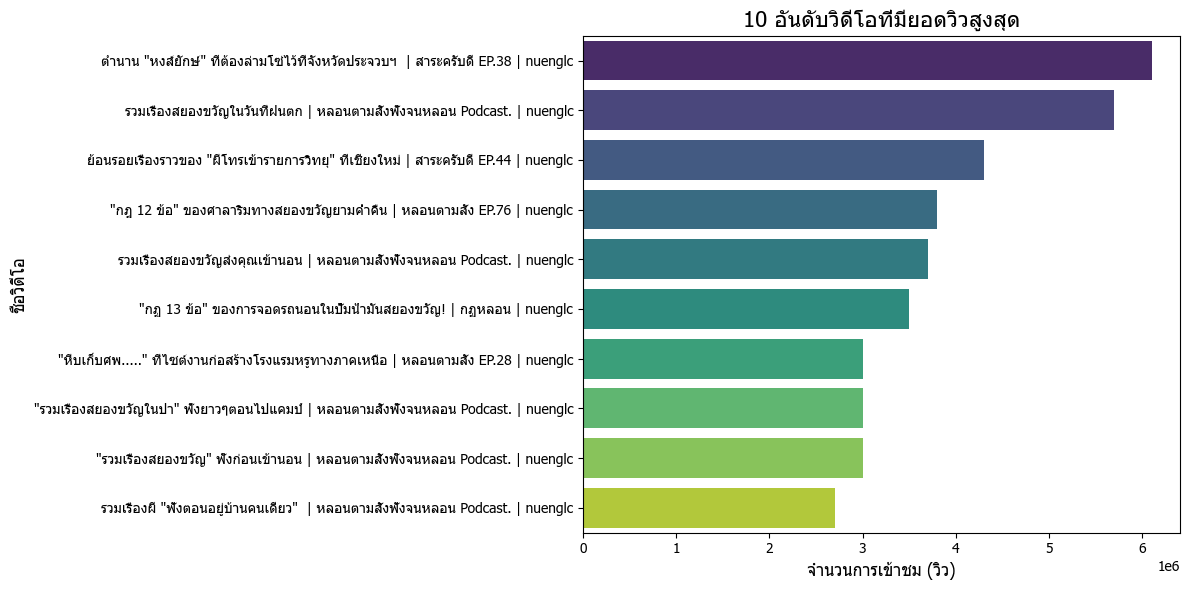

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ตั้งค่าให้ matplotlib รองรับภาษาไทย (Windows จะมี TH Sarabun หรือ AngsanaUPC)
plt.rcParams['font.family'] = 'Tahoma'   # ถ้าไม่มี Tahoma ลองใช้ 'TH Sarabun New' หรือ 'Angsana New'

# โหลด CSV
df = pd.read_csv(CSV_PATH, encoding="utf-8-sig")

# แปลง Views_Count เป็นตัวเลข
df = df.dropna(subset=["Views_Count"])
df["Views_Count"] = pd.to_numeric(df["Views_Count"], errors="coerce")

# --- Bar Chart: Top 10 วิดีโอ ---
top10 = df.sort_values(by="Views_Count", ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(data=top10, x="Views_Count", y="Title", palette="viridis")
plt.title("10 อันดับวิดีโอที่มียอดวิวสูงสุด", fontsize=16)
plt.xlabel("จำนวนการเข้าชม (วิว)", fontsize=12)
plt.ylabel("ชื่อวิดีโอ", fontsize=12)
plt.tight_layout()
plt.show()



## ขั้นตอนที่ 8 สร้างกราฟจำแนกประเภท

C:\Users\Oatbarley\AppData\Local\Temp\ipykernel_36260\501600410.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="Category", y="Views_Count", estimator=lambda x: sum(x)/len(x), palette="viridis")


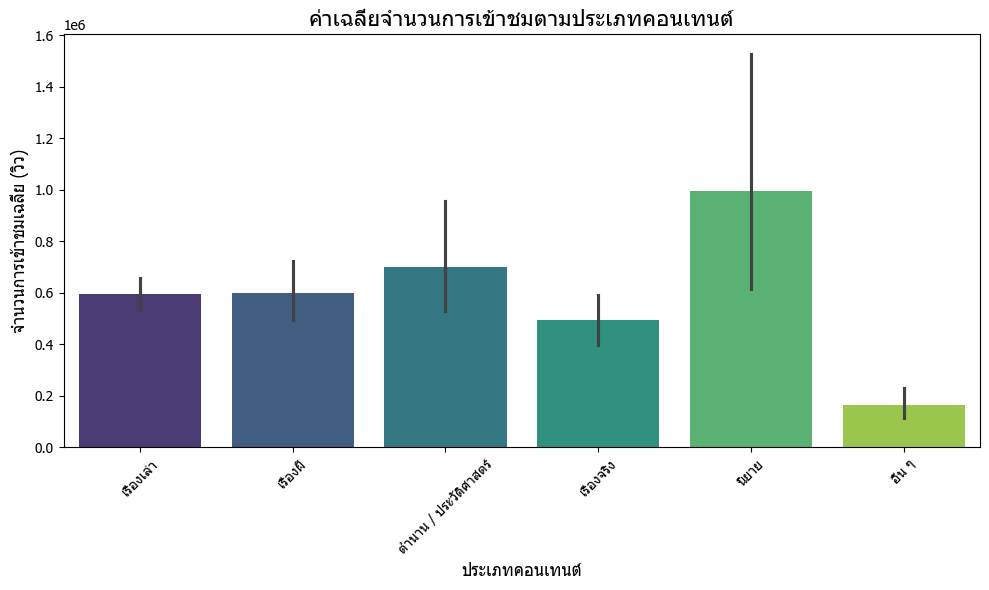

                Category    Views_Count
1                  นิยาย  993937.375000
0  ตำนาน / ประวัติศาสตร์  701874.953125
4               เรื่องผี  600348.732558
5             เรื่องเล่า  595167.568182
3             เรื่องจริง  493488.325581
2                 อื่น ๆ  166005.792208


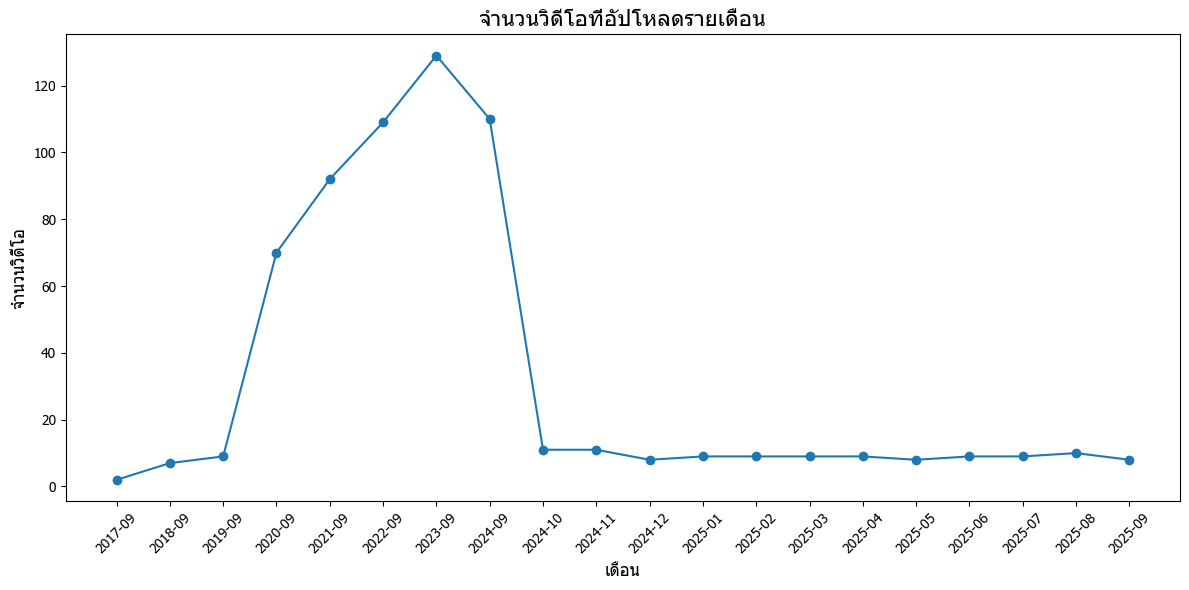

   YearMonth  Video_Count
0    2017-09            2
1    2018-09            7
2    2019-09            9
3    2020-09           70
4    2021-09           92
5    2022-09          109
6    2023-09          129
7    2024-09          110
8    2024-10           11
9    2024-11           11
10   2024-12            8
11   2025-01            9
12   2025-02            9
13   2025-03            9
14   2025-04            9
15   2025-05            8
16   2025-06            9
17   2025-07            9
18   2025-08           10
19   2025-09            8


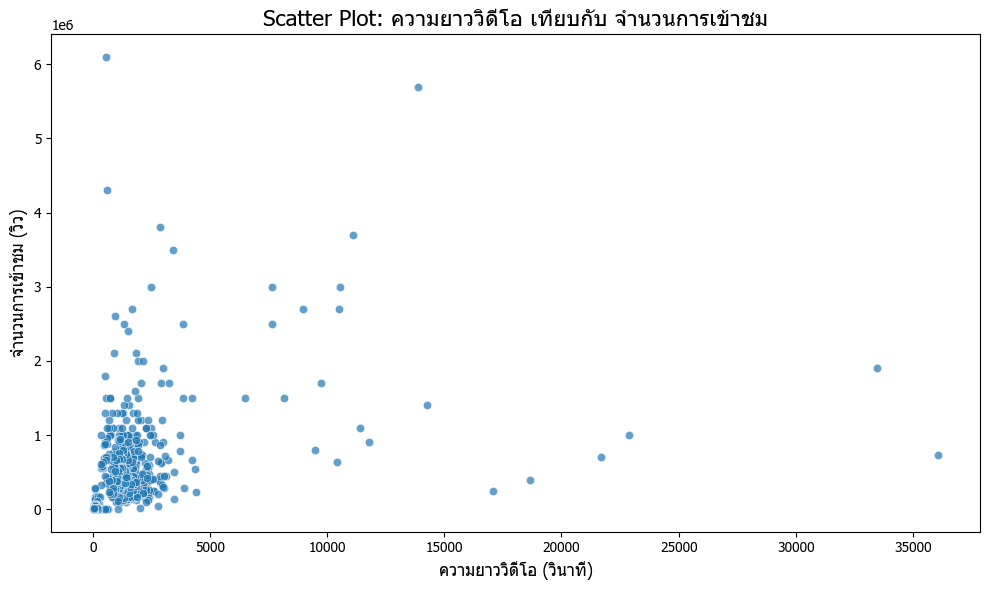

     Duration_Seconds  Views_Count
565               548      6100000
353             13886      5700000
553               628      4300000
456              2883      3800000
453             11104      3700000
413              3428      3500000
520              2500      3000000
429              7655      3000000
438             10537      3000000
445              8978      2700000
443              1680      2700000
411             10519      2700000
552               940      2600000
450              7643      2500000
242              3848      2500000
489              1320      2500000
534              1505      2400000
496              1859      2100000
549               923      2100000
508              2148      2000000
ค่าเฉลี่ยของความยาววิดีโอของ 20 อันดับแรกที่มียอดเข้าชมสูงสุดคือ: 4726.60 วินาที


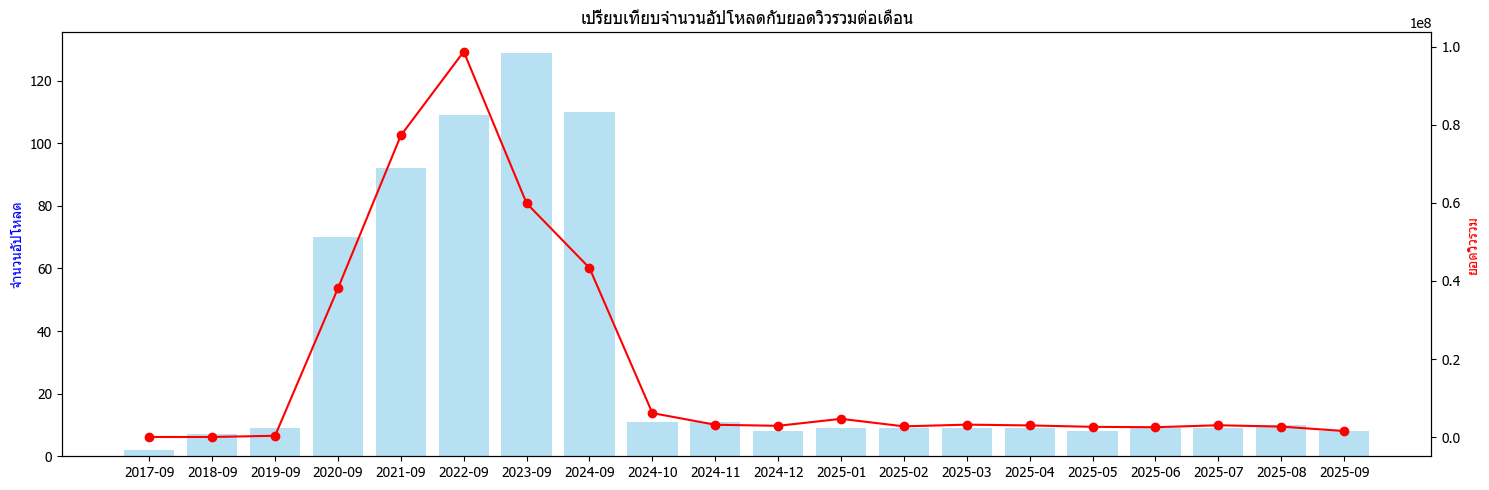

      month  upload_clip  total_views
0   2017-09            2        22400
1   2018-09            7        27400
2   2019-09            9       340800
3   2020-09           70     38108846
4   2021-09           92     77256999
5   2022-09          109     98742990
6   2023-09          129     59889992
7   2024-09          110     43319996
8   2024-10           11      6149998
9   2024-11           11      3160000
10  2024-12            8      2889999
11  2025-01            9      4680000
12  2025-02            9      2749999
13  2025-03            9      3189999
14  2025-04            9      2989999
15  2025-05            8      2629999
16  2025-06            9      2529999
17  2025-07            9      3030000
18  2025-08           10      2689999
19  2025-09            8      1555000


In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ตั้งค่าให้ matplotlib รองรับภาษาไทย (Windows จะมี TH Sarabun หรือ AngsanaUPC)
plt.rcParams['font.family'] = 'Tahoma' 

# โหลดข้อมูล

df = pd.read_csv(CSV_PATH, encoding="utf-8-sig")

# --- เตรียมข้อมูล ---
# แปลง Views_Count เป็นตัวเลข
if "Views_Count" in df.columns:
    df["Views_Count"] = pd.to_numeric(df["Views_Count"], errors="coerce")

# แปลง Published เป็น datetime
if "Published" in df.columns:
    df["Published"] = pd.to_datetime(df["Published"], errors="coerce")

# --- 1. Bar Chart: ค่าเฉลี่ย Views ตามประเภทคอนเทนต์ ---
if "Category" in df.columns:
    plt.figure(figsize=(10,6))
    sns.barplot(data=df, x="Category", y="Views_Count", estimator=lambda x: sum(x)/len(x), palette="viridis")
    plt.title("ค่าเฉลี่ยจำนวนการเข้าชมตามประเภทคอนเทนต์", fontsize=16)
    plt.xlabel("ประเภทคอนเทนต์", fontsize=12)
    plt.ylabel("จำนวนการเข้าชมเฉลี่ย (วิว)", fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    category_avg_views = df.groupby('Category')['Views_Count'].mean().reset_index()
    sorted_categories = category_avg_views.sort_values(by='Views_Count', ascending=False)
    print(sorted_categories)

else:
    print("ไม่พบคอลัมน์ Category ในข้อมูล")

# --- 2. Line Chart: จำนวนวิดีโอที่อัปโหลดรายเดือน ---
if "Published" in df.columns:
    df_month = df.dropna(subset=["Published"]).copy()
    df_month["YearMonth"] = df_month["Published"].dt.to_period("M")
    uploads_per_month = df_month.groupby("YearMonth").size().reset_index(name="Video_Count")

    plt.figure(figsize=(12,6))
    plt.plot(uploads_per_month["YearMonth"].astype(str), uploads_per_month["Video_Count"], marker="o")
    plt.title("จำนวนวิดีโอที่อัปโหลดรายเดือน", fontsize=16)
    plt.xlabel("เดือน", fontsize=12)
    plt.ylabel("จำนวนวิดีโอ", fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print(uploads_per_month)
else:
    print("ไม่พบคอลัมน์ Published ในข้อมูล")

# --- 3. Scatter Plot: Duration เทียบกับ Views ---
if "Duration_Seconds" in df.columns and "Views_Count" in df.columns:
    df_duration = df.dropna(subset=["Duration_Seconds", "Views_Count"]).copy()

    plt.figure(figsize=(10,6))
    sns.scatterplot(data=df_duration, x="Duration_Seconds", y="Views_Count", alpha=0.7)
    plt.title("Scatter Plot: ความยาววิดีโอ เทียบกับ จำนวนการเข้าชม", fontsize=16)
    plt.xlabel("ความยาววิดีโอ (วินาที)", fontsize=12)
    plt.ylabel("จำนวนการเข้าชม (วิว)", fontsize=12)
    plt.tight_layout()
    plt.show()
    
    sorted_df = df_duration.sort_values(by="Views_Count", ascending=False)
    print(sorted_df[["Duration_Seconds", "Views_Count"]].head(20))

    # 1. เรียงข้อมูลตามยอดเข้าชมจากมากไปน้อย
    top_20_by_views = df.sort_values(by="Views_Count", ascending=False)
    # 2. เลือก 20 อันดับแรกและคำนวณค่าเฉลี่ยของความยาววิดีโอ
    average_duration_of_top_20 = top_20_by_views.head(20)['Duration_Seconds'].mean()
    print(f"ค่าเฉลี่ยของความยาววิดีโอของ 20 อันดับแรกที่มียอดเข้าชมสูงสุดคือ: {average_duration_of_top_20:.2f} วินาที")
else:
    print("ไม่พบคอลัมน์ Duration_Seconds หรือ Views_Count ในข้อมูล")
    
# --- 4.Published เทียบกับ Views_Count ---
if "Published" in df.columns and "Views_Count" in df.columns:
    df_duration = df.dropna(subset=["Published", "Views_Count"]).copy()
    df['month'] = df['Published'].dt.to_period('M')
    uploads_per_month = df.groupby('month').size()
    views_per_month = df.groupby('month')['Views_Count'].sum()

    fig, ax1 = plt.subplots(figsize=(15,5))

    ax1.bar(uploads_per_month.index.astype(str), uploads_per_month.values, 
        color='skyblue', alpha=0.6, label='จำนวนอัปโหลด')
    ax1.set_ylabel("จำนวนอัปโหลด", color='blue')

    ax2 = ax1.twinx()
    ax2.plot(views_per_month.index.astype(str), views_per_month.values, 
        color='red', marker='o', label='ยอดวิวรวม')
    ax2.set_ylabel("ยอดวิวรวม", color='red')

    plt.title("เปรียบเทียบจำนวนอัปโหลดกับยอดวิวรวมต่อเดือน")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    grouped_data = df.groupby('month').agg(
    upload_clip=('month', 'size'),
    total_views=('Views_Count', 'sum')
    ).reset_index()

    print(grouped_data)

else:
    print("❌ ไม่พบคอลัมน์ Published หรือ Views_Count ในข้อมูล")